# Markov Chain Monte Carlo Example

Inference of a distribution using Markov Chain Monte Carlo (MCMC) sampling (a very much simplified version of the implementation in BATEA).
This a slightly more complicated implementation of what you saw in the MCMC rating curves.  It is a simplified version of that found in BATEA (which is the hydrological model implementation that Brian Henn used in his work to determine what precipitation must have been given measurements of streamflow).

Note, this lab is designed to let you test the influence of selecting a gaussian or uniform prior, a gaussian or uniform liklihood, and of the number of samples needed, by comparing the MCMC approach to the theoretical distributions.

Derived from MCMCexample_noQN.m (Brian Henn, UW, February 2015)

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

%matplotlib inline

Inputs

In [2]:
# Specify prior distribution type ('uniform', or 'gaussian')
# this allows you to explore the impact of the shape of the prior distribution
PriorDistType = 'gaussian'

# Specify prior parameters (a=lower bound/mean, b=upper bound/st. dev)
aP = -2
bP = 2

# specify likelihood function type ('uniform', or 'gaussian')
LikelihoodDistType = 'gaussian'

# specify likelihood parameters (a = lower bound/mean, b = upper bound/st. dev.)
aL = 1
bL = 4

# MCMC parameters
nChains = 1
nSamples = int(1e5)
parJump = 1
dxMCMC = 1e-1

burn_in = int(1e2)

In [3]:
# Define evalBayes

def evalBayes(PriorDistType,LikelihoodDistType,aP,bP,aL,bL,x):
   
    if PriorDistType == 'uniform': # For a uniform prior distribution
        if (x >= aP) & (x <= bP):
            xPrior = 1/(bP - aP)
        else:
            xPrior = 0
    elif PriorDistType == 'gaussian': # For a Gaussian prior distribution
        xPrior = st.norm.pdf(x,aP,bP)

    if LikelihoodDistType == 'uniform': # For a uniform likelihood distribution
        if (x >= aL) & (x <= bL):
            xLikelihood = 1/(bL - aL)
        else:
            xLikelihood = 0  
    elif LikelihoodDistType == 'gaussian': # For a Gaussian likelihood distribution
        xLikelihood = st.norm.pdf(x,aL,bL)
    
    Post = xLikelihood*xPrior
    
    return Post

Define "analytical" solution:

In [4]:
# define "analytical" solution
# Note that we are going to compare analytical updates to the prior (like we did in homework 5)
# with MCMC updates to the prior, as a way to test how well the MCMC method works.

X = np.linspace(-10,10,1001)

# Prior Distribution
if PriorDistType == 'uniform': # For a uniform prior distribution
    PriorDist = np.zeros_like(X)
    PriorDist[(X >= aP) & (X <= bP)] = 1/(bP-aP)
elif PriorDistType == 'gaussian': # For a Gaussian prior distribution
    PriorDist = st.norm.pdf(X,aP,bP)

# Likelihood Distribution
if LikelihoodDistType == 'uniform': # For a uniform likelihood distribution
    LikelihoodDist = np.zeros_like(X)
    LikelihoodDist[(X >= aL) & (X <= bL)] = 1/(bL-aL)
elif LikelihoodDistType == 'gaussian': # For a Gaussian likelihood distribution
    LikelihoodDist = st.norm.pdf(X,aL,bL)


In [5]:

PosteriorDist = np.zeros_like(X)

for i in range (0, X.size):
    x = X[i]
    PosteriorDist[i] = evalBayes(PriorDistType,LikelihoodDistType,aP,bP,aL,bL,x)



if np.sum(PosteriorDist) == 0:
    scaleRatio = np.sum(LikelihoodDist)/np.sum(PriorDist)
else:
    scaleRatio = np.sum(PosteriorDist)/np.sum(PriorDist)

Text(0.5, 1.0, 'Analytical Solution')

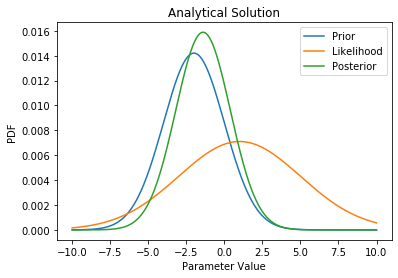

In [6]:
plt.figure()
plt.plot(X,scaleRatio*PriorDist,label='Prior')
plt.plot(X,scaleRatio*LikelihoodDist,label='Likelihood')
plt.plot(X,PosteriorDist,label='Posterior')
plt.legend(loc='best')
plt.xlabel('Parameter Value')
plt.ylabel('PDF')
plt.title('Analytical Solution')

Now run the MCMC chains, using the most likely value of the prior as the starting point.

(Note that more clever methods exist to pick the starting point)

In [7]:
xStartMCMC = np.sum(X*PriorDist) / np.sum(PriorDist) #expected value, or mean of the pior distribution

fStartMCMC = evalBayes(PriorDistType,LikelihoodDistType,aP,bP,aL,bL,xStartMCMC) 

Samples = np.empty([nSamples,nChains])
for i in range(0, nChains):
    x = xStartMCMC
    f = fStartMCMC
    for j in range(1, nSamples):
        # propose jump and decide
        distJump = dxMCMC*np.random.normal()
        fJump = evalBayes(PriorDistType,LikelihoodDistType,aP,bP,aL,bL,x + distJump)
        if fJump >= f:
            xNew = x + distJump
            fNew = fJump
        else:
            randNum = np.random.uniform()
            try: # try-except statement to handle zero division with uniform distributions
                if randNum < (fJump/f)**parJump:
                    xNew = x + distJump
                    fNew = fJump
                else:
                    xNew = x
                    fNew = f
            except ZeroDivisionError:
                xNew = x
                fNew = f 
        x = xNew
        f = fNew
        Samples[j,i] = x

In [8]:
a = np.histogram(Samples[burn_in:],X)[0] * (np.sum(PosteriorDist)/Samples[burn_in:].size);

In [9]:
if np.sum(PosteriorDist) == 0:
    scaleRatio = np.sum(LikelihoodDist)/np.sum(PriorDist)
else:
    scaleRatio = np.sum(PosteriorDist)/np.sum(PriorDist)

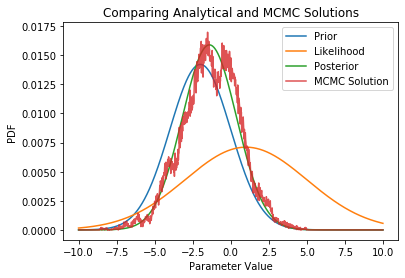

In [10]:
plt.figure()
plt.plot(X,scaleRatio*PriorDist,label='Prior')
plt.plot(X,scaleRatio*LikelihoodDist,label='Likelihood')
plt.plot(X,PosteriorDist,label='Posterior')
plt.plot(X[1:],a,label='MCMC Solution',alpha=0.8)

plt.xlabel('Parameter Value')
plt.ylabel('PDF')
plt.title('Comparing Analytical and MCMC Solutions')
plt.legend(loc='best')